In [1]:
from __future__ import annotations
from abc        import ABC, abstractmethod
from typing     import List

import sys
sys.path.insert(0, '../../..')

import warnings
warnings.filterwarnings("ignore")
import joblib
import requests
import configparser
import asyncio
from binance.client import Client as BinanceClient
from binance.client import AsyncClient
from binance        import BinanceSocketManager
import pandas as pd
import numpy  as np

from ta import momentum, trend, volatility
from ta import volume as tavolume

import mlfinlab as fml

from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
df = pd.read_csv("/home/sharav/src/binance-history-downloader/data/klines/BTCUSDT-1m-spot.csv", parse_dates=True, index_col="timestamp")

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,23125.40,23112.33,23116.25,157.814340
2023-02-28 23:56:00,23115.30,23122.93,23112.64,23121.22,66.582270
2023-02-28 23:57:00,23121.73,23137.39,23117.41,23121.42,165.619490


In [3]:
def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [4]:
class MLInterface:
    def __init__(self):
        self.primary_threshold = 0.65

        self.side_features = []
        self.meta_features = []
        with open("../../../asset_btcusdt/meta-ml/model/features_side.txt", "r") as f:
            self.side_features = f.readlines()[0].strip().split()
        with open("../../../asset_btcusdt/meta-ml/model/features_meta.txt", "r") as f:
            self.meta_features = f.readlines()[0].strip().split()
        print(f"side features : {self.side_features}")
        print(f"meta features : {self.meta_features}")
        self.side_rf = joblib.load("../../../asset_btcusdt/meta-ml/model/btcusdt_rf_side.save")
        self.meta_rf = joblib.load("../../../asset_btcusdt/meta-ml/model/btcusdt_rf_meta.save")
        print(self.side_rf)
        print(self.meta_rf)

    def do_inference(self, df):
        df["volatility_tpsl"] = get_daily_volatility(close=df['Close'], lookback=600)

        # primary features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
        df["sma_440"            ] = trend.sma_indicator(df['Close'], window=440)
        df["ma_440"             ] = df['Close']/df[f"sma_440"]-1.0
        df["daily_volatility_30"] = fml.util.get_daily_vol(close=df['Close'], lookback = 30)
        df["vm_eom_25"          ] = tavolume.ease_of_movement(df['High'], df['Low'], df['Volume'], window=25)
        df["vl_atr_180"         ] = volatility.average_true_range(df['High'], df['Low'], df['Close'], window=180)
        df["vm_cmf_180"         ] = tavolume.chaikin_money_flow(df['High'], df['Low'], df['Close'], df['Volume'], window=180)
        # meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
        df["vl_bbp"             ] = volatility.bollinger_pband(df['Close'])
        df["t_adx_90"           ] = trend.adx(df['High'], df['Low'], df['Close'], window=90)
        df["momentum_1"         ] = df['Close'].pct_change(periods=1)
        df["close_sign"         ] = df['momentum_1'].apply(np.sign)
        df["close_plus_minus_40"] = df['close_sign'].rolling(40).apply(lambda x: x.sum())

        df = df.fillna(0.0)

        df['side'] = self.side_rf.predict(df[self.side_features]) 
        df.loc[df['side']==-1, 'prob'] = self.side_rf.predict_proba(df[df['side']==-1][self.side_features])[:,0]
        df.loc[df['side']== 1, 'prob'] = self.side_rf.predict_proba(df[df['side']== 1][self.side_features])[:,1]
        df['is_signal'] = False
        df.loc[(df['prob']>=self.primary_threshold)|(df['prob']>=self.primary_threshold), 'is_signal'] = True

        signal_indexes = df[df['is_signal']==True].index
        df['act'] = 0
        df.loc[signal_indexes, 'act'     ] = self.meta_rf.predict(df.loc[signal_indexes][self.meta_features])
        df.loc[signal_indexes, 'act_prob'] = self.meta_rf.predict_proba(df.loc[signal_indexes][self.meta_features])[:,1]

        return df

In [5]:
ml_inference = MLInterface()

side features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)


In [6]:
df = ml_inference.do_inference(df)

df

,Open,High,Low,Close,Volume,volatility_tpsl,sma_440,ma_440,daily_volatility_30,vm_eom_25,...,vl_bbp,t_adx_90,momentum_1,close_sign,close_plus_minus_40,side,prob,is_signal,act,act_prob
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.004477,1.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,...,0.000000,0.000000,-0.004457,-1.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,23125.40,23112.33,23116.25,157.814340,0.008328,23309.565932,-0.008293,0.001386,-8.381266e+07,...,-0.027707,13.958657,-0.000343,-1.0,-2.0,1.0,0.602669,False,0,NaN
2023-02-28 23:56:00,23115.30,23122.93,23112.64,23121.22,66.582270,0.008342,23308.785341,-0.008047,0.001358,-1.669093e+07,...,0.118305,13.927030,0.000215,1.0,-2.0,1.0,0.604077,False,0,NaN
2023-02-28 23:57:00,23121.73,23137.39,23117.41,23121.42,165.619490,0.008356,23307.974000,-0.008004,0.001339,1.159934e+08,...,0.142375,13.873442,0.000009,1.0,-2.0,1.0,0.658882,True,1,0.500595


In [7]:
df['is_signal'].value_counts()

False    2484474
True      418485
Name: is_signal, dtype: int64

In [8]:
df['position'] = df['side']

In [9]:
df['position'].value_counts()

 1.0    1457445
-1.0    1445514
Name: position, dtype: int64

<AxesSubplot: >

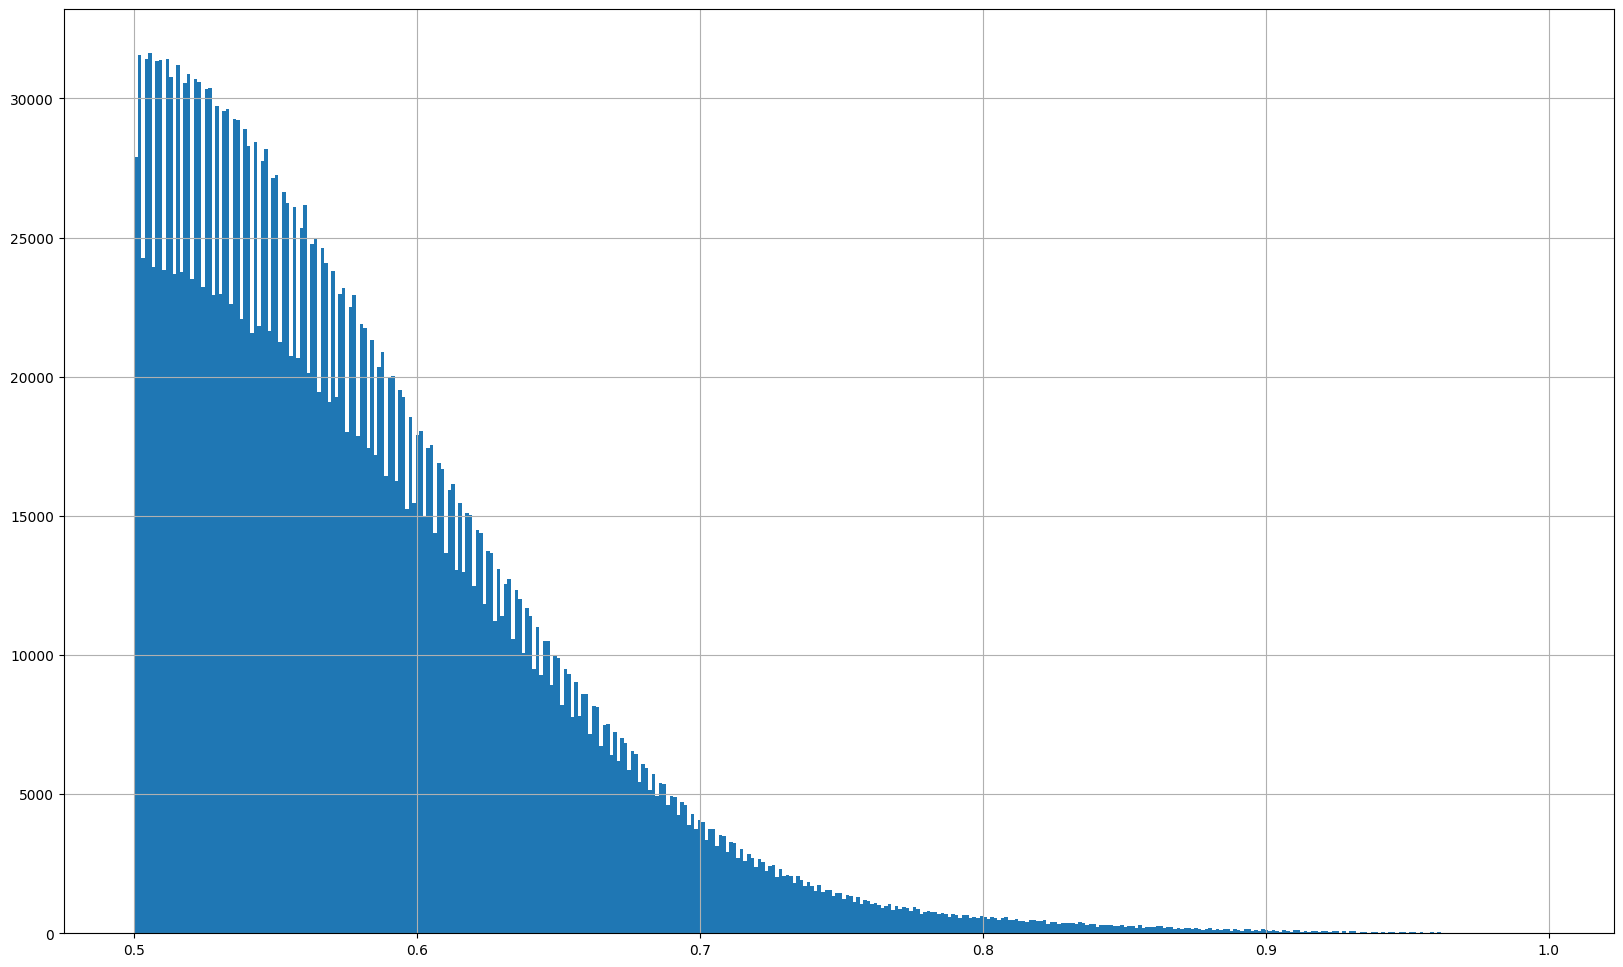

In [10]:
df['prob'].hist(bins=400)

In [11]:
df['volatility_tpsl'] = get_daily_volatility(close=df['Close'], lookback=840)

In [14]:
# Model performance evaluation on OOS data

import datetime
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

def kelly(prob_win, payout_perc):
    return (prob_win * payout_perc - (1 - prob_win)) / payout_perc

binance_commission = 0.0004  # Taker Fee rate is 0.04%

RR         = 1.2
sl_target  = 1.0
long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]
ptsl       = [round(sl_target*RR, 2), round(sl_target*RR, 2)]

In [38]:
act_threshold = 0.65

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   95.601794
Equity Final [$]             102790427.230033
Equity Peak [$]              103815836.014667
Return [%]                           2.790427
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    2.948412
Volatility (Ann.) [%]                5.772208
Sharpe Ratio                         0.510794
Sortino Ratio                        0.762774
Calmar Ratio                         0.634229
Max. Drawdown [%]                   -4.648816
Avg. Drawdown [%]                   -0.125565
Max. Drawdown Duration      192 days 11:24:00
Avg. Drawdown Duration        2 days 10:18:00
# Trades                                 1645
Win Rate [%]                        47.659574
Best Trade [%]                       5.000464
Worst Trade [%]                      -4.72367
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,78
,Backtest
Annual return,1.8%
Cumulative returns,12.4%
Annual volatility,23.2%
Sharpe ratio,0.19
Calmar ratio,0.04
Stability,0.33
Max drawdown,-40.5%


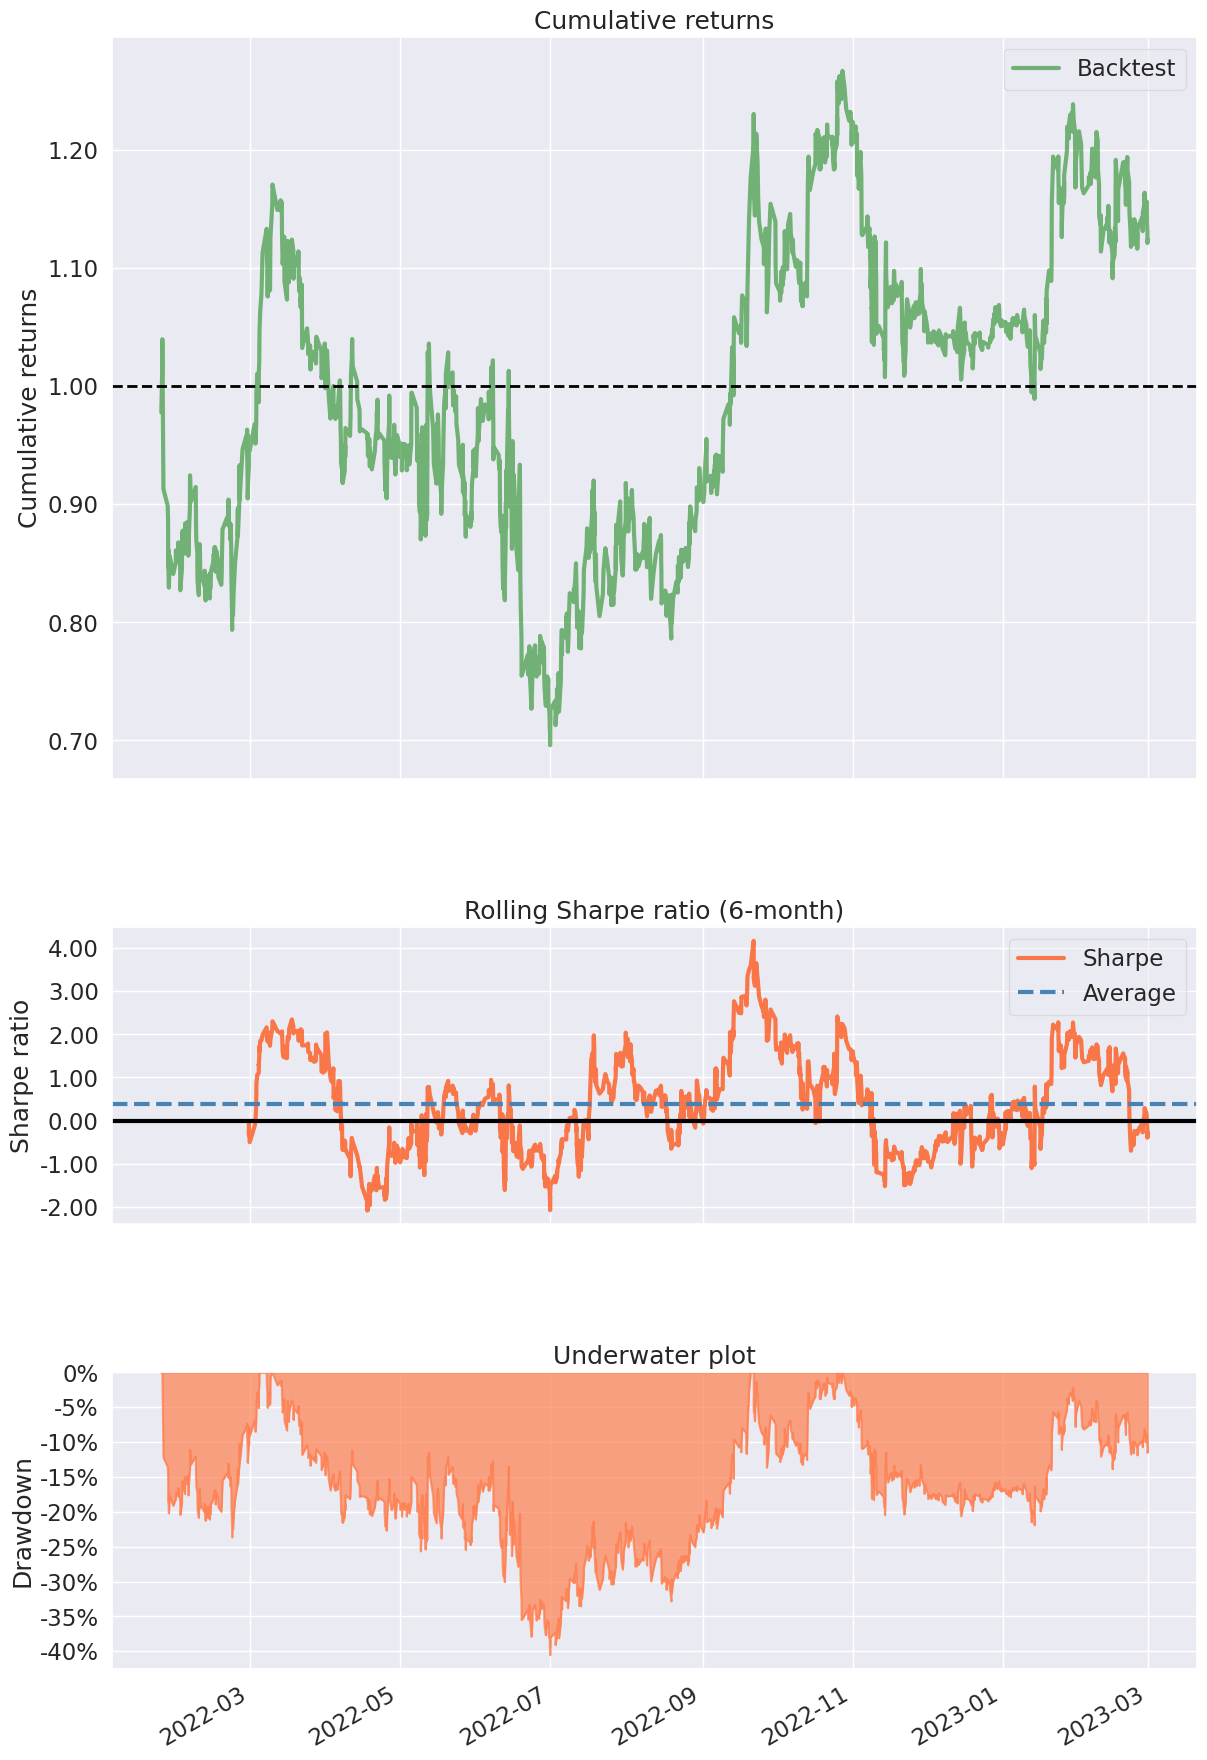

In [39]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [40]:
act_threshold = 0.66

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   94.036437
Equity Final [$]             104730275.791911
Equity Peak [$]              106916974.340529
Return [%]                           4.730276
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    3.080326
Volatility (Ann.) [%]                6.000396
Sharpe Ratio                         0.513354
Sortino Ratio                        0.777339
Calmar Ratio                         0.795113
Max. Drawdown [%]                   -3.874071
Avg. Drawdown [%]                   -0.102127
Max. Drawdown Duration      125 days 22:12:00
Avg. Drawdown Duration        1 days 06:13:00
# Trades                                 1555
Win Rate [%]                        47.909968
Best Trade [%]                       4.994956
Worst Trade [%]                      -4.72367
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,74
,Backtest
Annual return,5.2%
Cumulative returns,36.3%
Annual volatility,23.5%
Sharpe ratio,0.33
Calmar ratio,0.15
Stability,0.66
Max drawdown,-34.9%


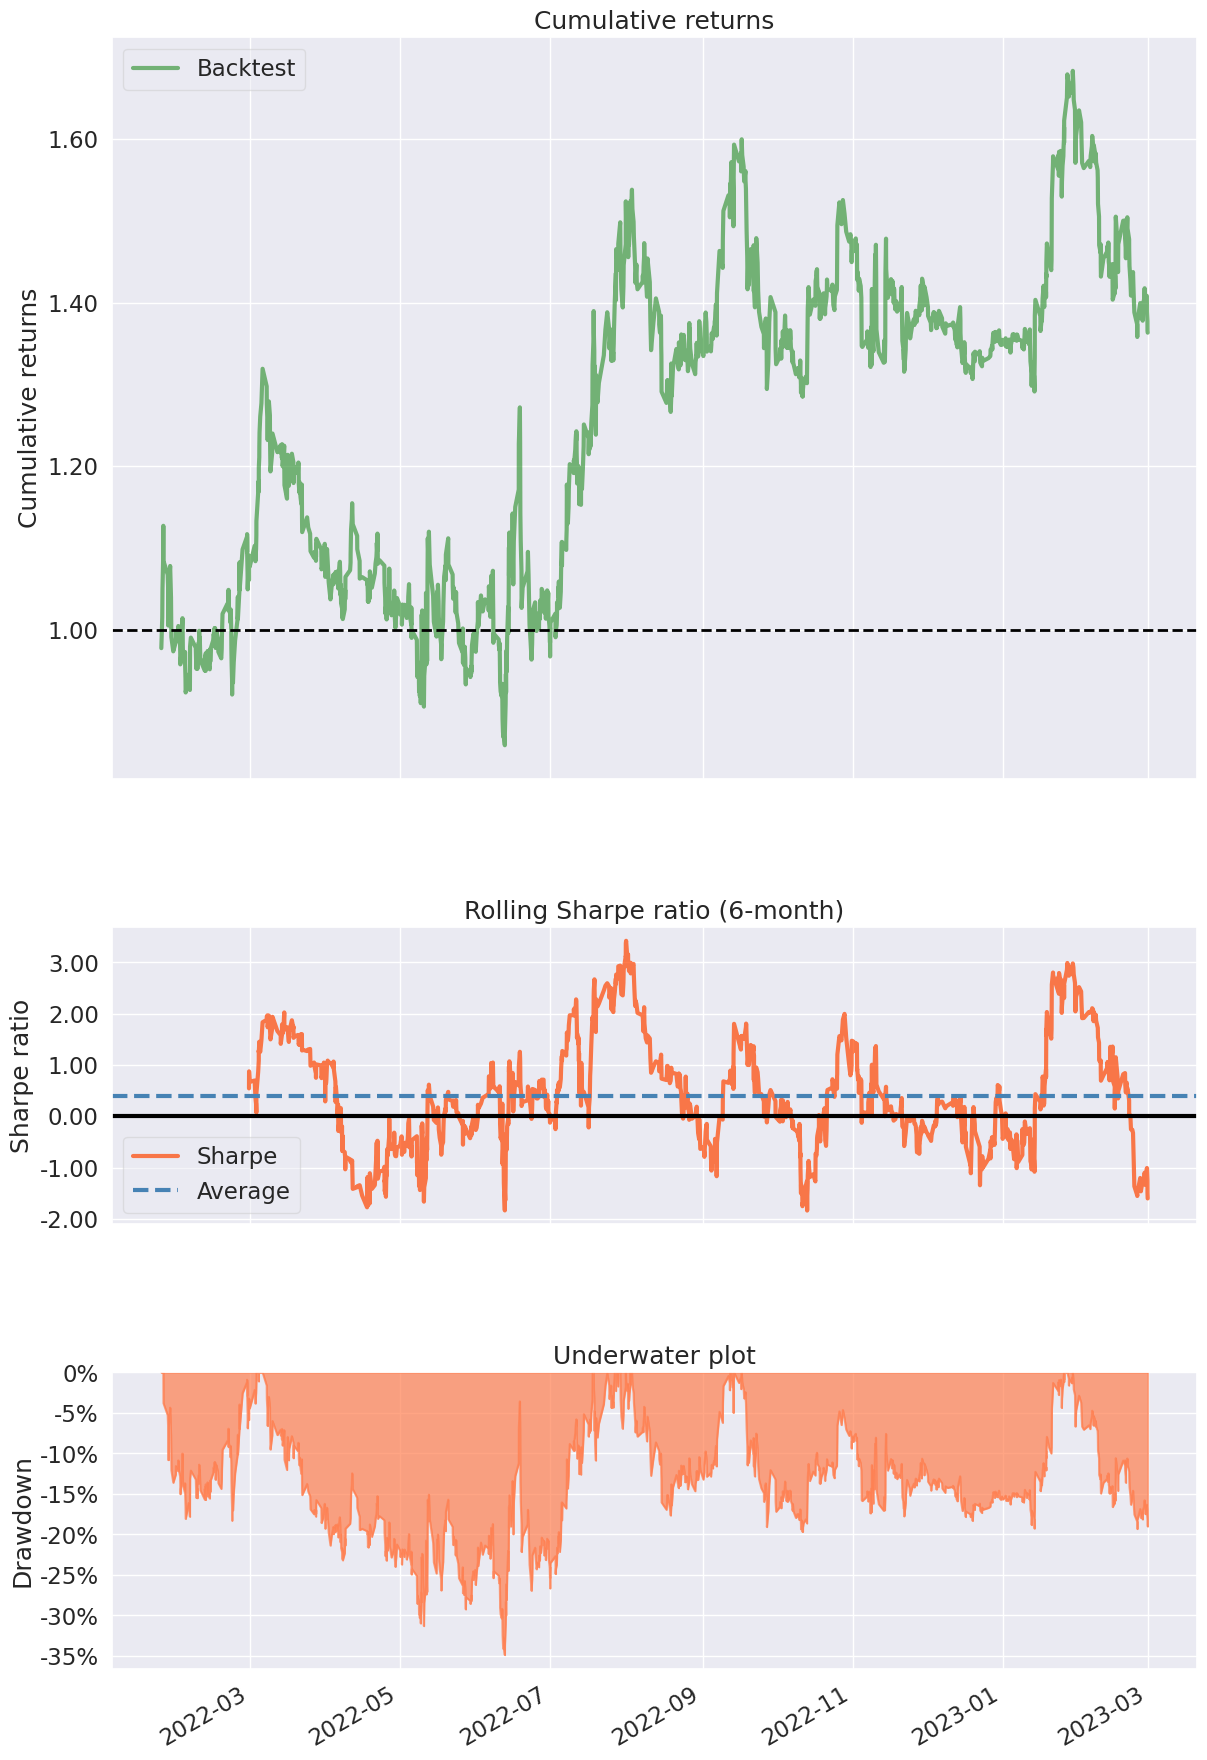

In [41]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [42]:
act_threshold = 0.67

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   92.406137
Equity Final [$]             104351172.213888
Equity Peak [$]               106936801.38937
Return [%]                           4.351172
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    2.739344
Volatility (Ann.) [%]                6.154261
Sharpe Ratio                         0.445113
Sortino Ratio                        0.709664
Calmar Ratio                         0.509668
Max. Drawdown [%]                   -5.374764
Avg. Drawdown [%]                   -0.111036
Max. Drawdown Duration      144 days 23:40:00
Avg. Drawdown Duration        1 days 05:37:00
# Trades                                 1508
Win Rate [%]                        47.679045
Best Trade [%]                       5.148793
Worst Trade [%]                     -4.730221
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,71
,Backtest
Annual return,4.7%
Cumulative returns,31.3%
Annual volatility,24.0%
Sharpe ratio,0.31
Calmar ratio,0.10
Stability,0.54
Max drawdown,-44.4%


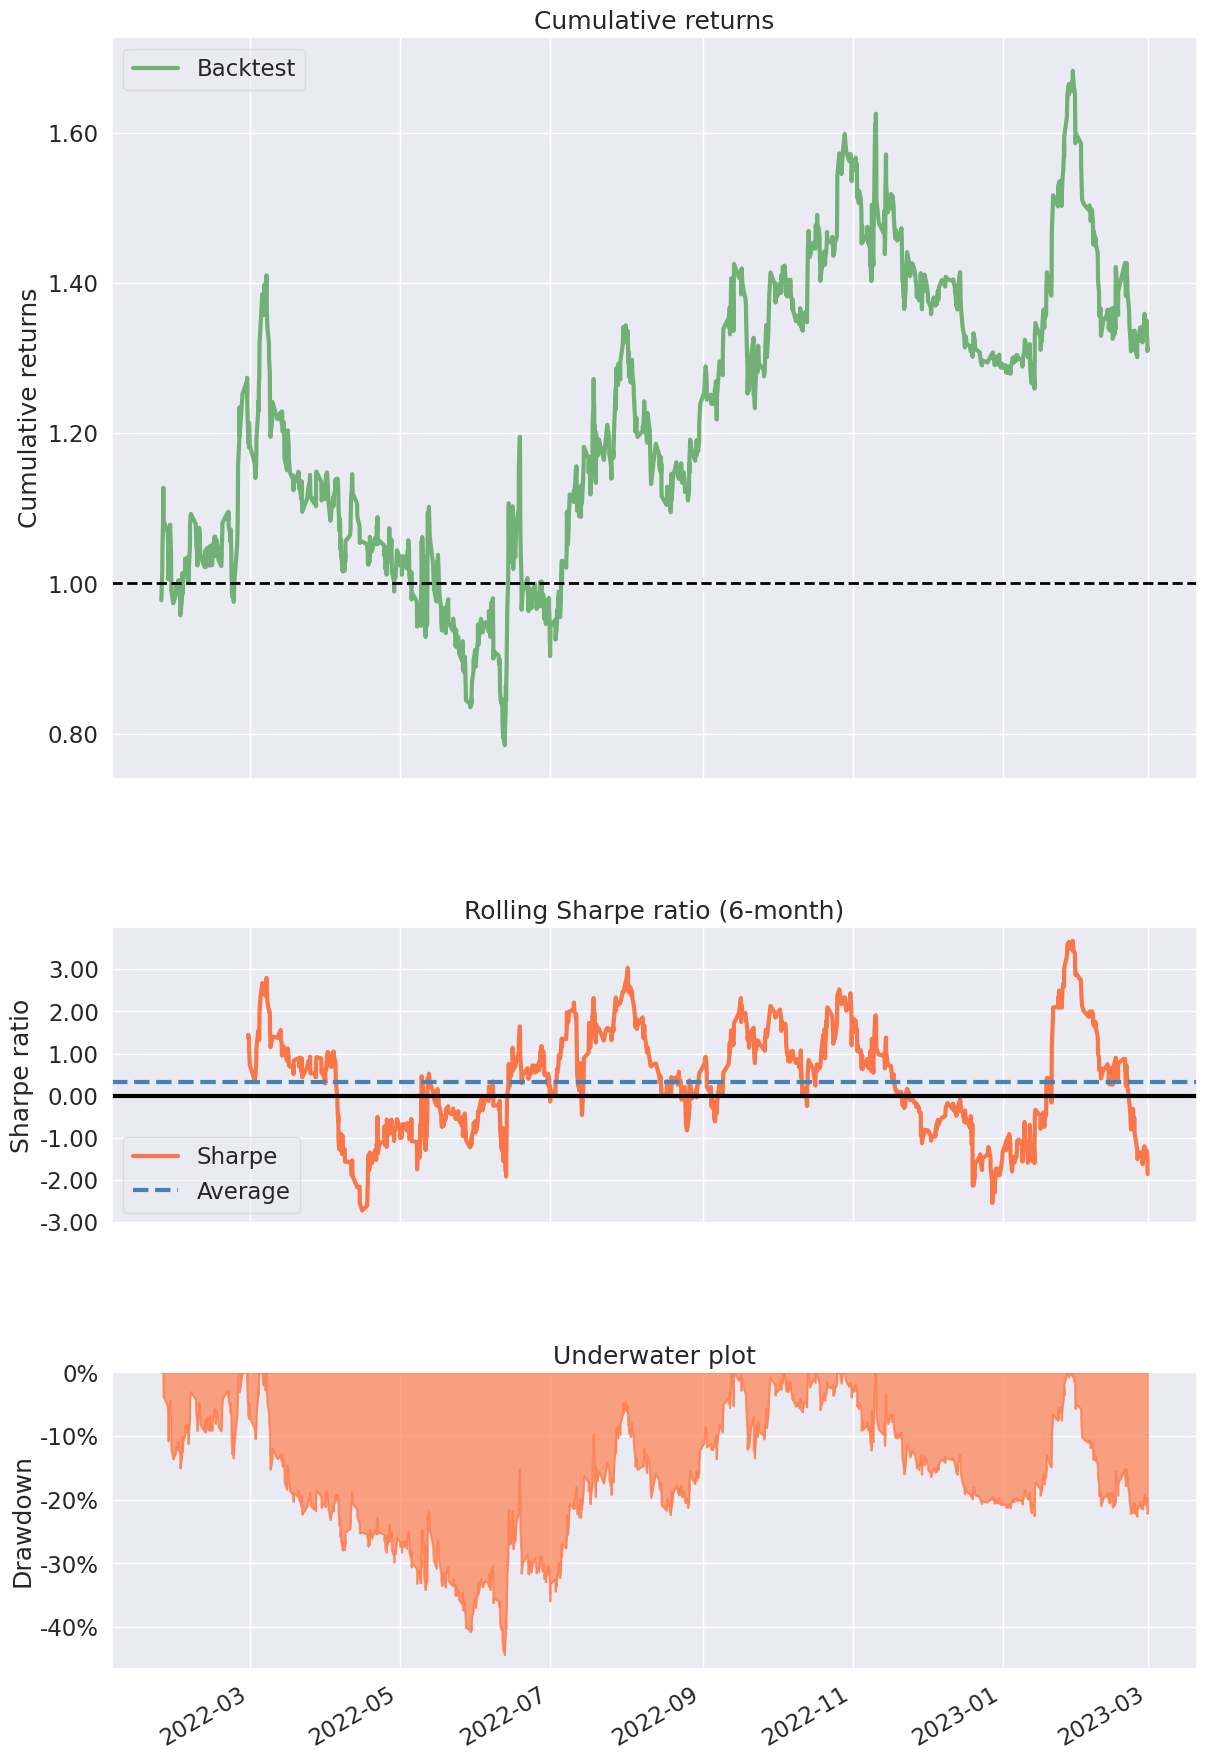

In [43]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [44]:
act_threshold = 0.68

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   90.501351
Equity Final [$]             103848507.623445
Equity Peak [$]              105915424.765449
Return [%]                           3.848508
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    3.182131
Volatility (Ann.) [%]                6.198315
Sharpe Ratio                         0.513386
Sortino Ratio                        0.855366
Calmar Ratio                          0.70059
Max. Drawdown [%]                    -4.54207
Avg. Drawdown [%]                   -0.102887
Max. Drawdown Duration      247 days 07:11:00
Avg. Drawdown Duration        1 days 16:44:00
# Trades                                 1450
Win Rate [%]                        47.241379
Best Trade [%]                       5.632058
Worst Trade [%]                     -4.643493
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,69
,Backtest
Annual return,3.9%
Cumulative returns,24.8%
Annual volatility,24.6%
Sharpe ratio,0.28
Calmar ratio,0.09
Stability,0.13
Max drawdown,-42.7%


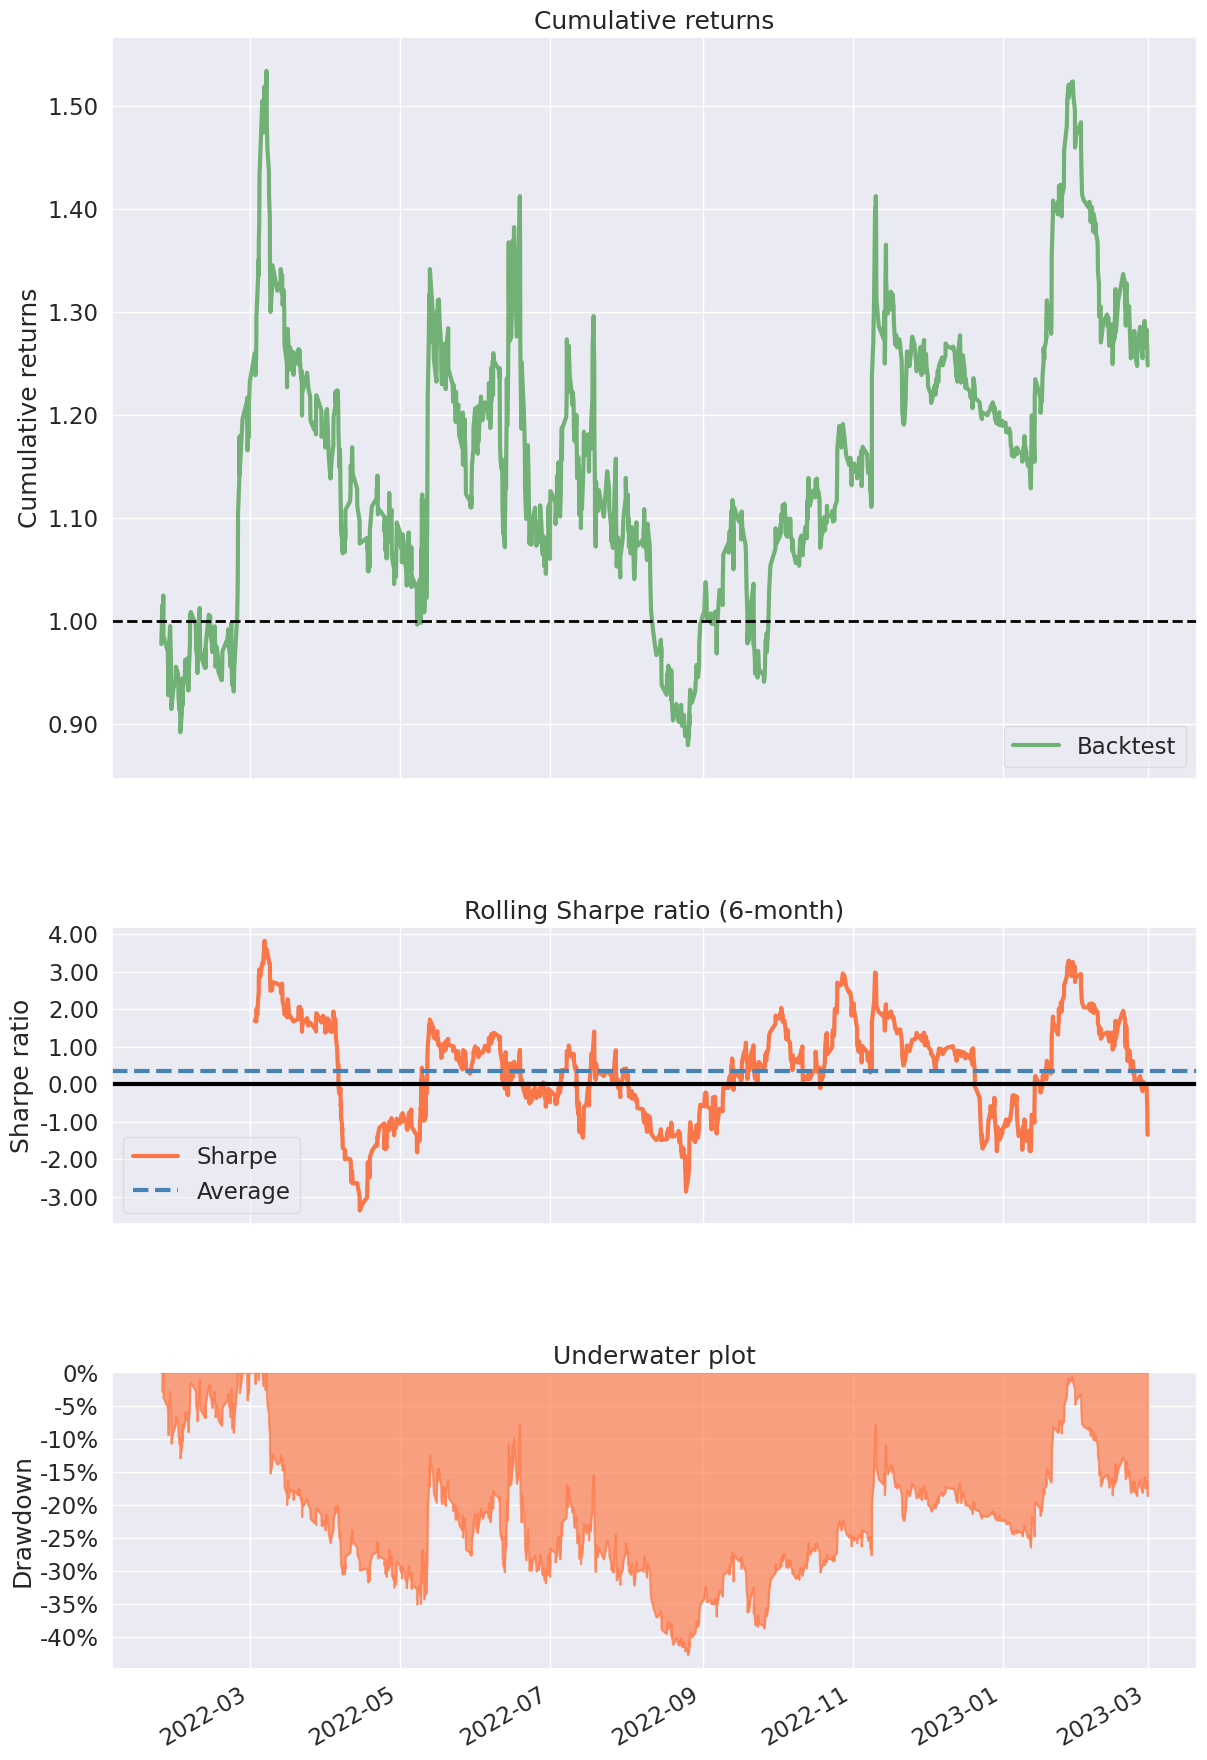

In [45]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [46]:
act_threshold = 0.69

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   88.119805
Equity Final [$]               103482905.4582
Equity Peak [$]              104184361.937457
Return [%]                           3.482905
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    3.407441
Volatility (Ann.) [%]                6.547157
Sharpe Ratio                         0.520446
Sortino Ratio                         0.90644
Calmar Ratio                         0.797388
Max. Drawdown [%]                   -4.273251
Avg. Drawdown [%]                   -0.147409
Max. Drawdown Duration      144 days 17:05:00
Avg. Drawdown Duration        2 days 06:37:00
# Trades                                 1334
Win Rate [%]                        47.151424
Best Trade [%]                       5.632058
Worst Trade [%]                     -4.666027
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,63
,Backtest
Annual return,3.7%
Cumulative returns,21.0%
Annual volatility,25.3%
Sharpe ratio,0.27
Calmar ratio,0.09
Stability,0.08
Max drawdown,-40.1%


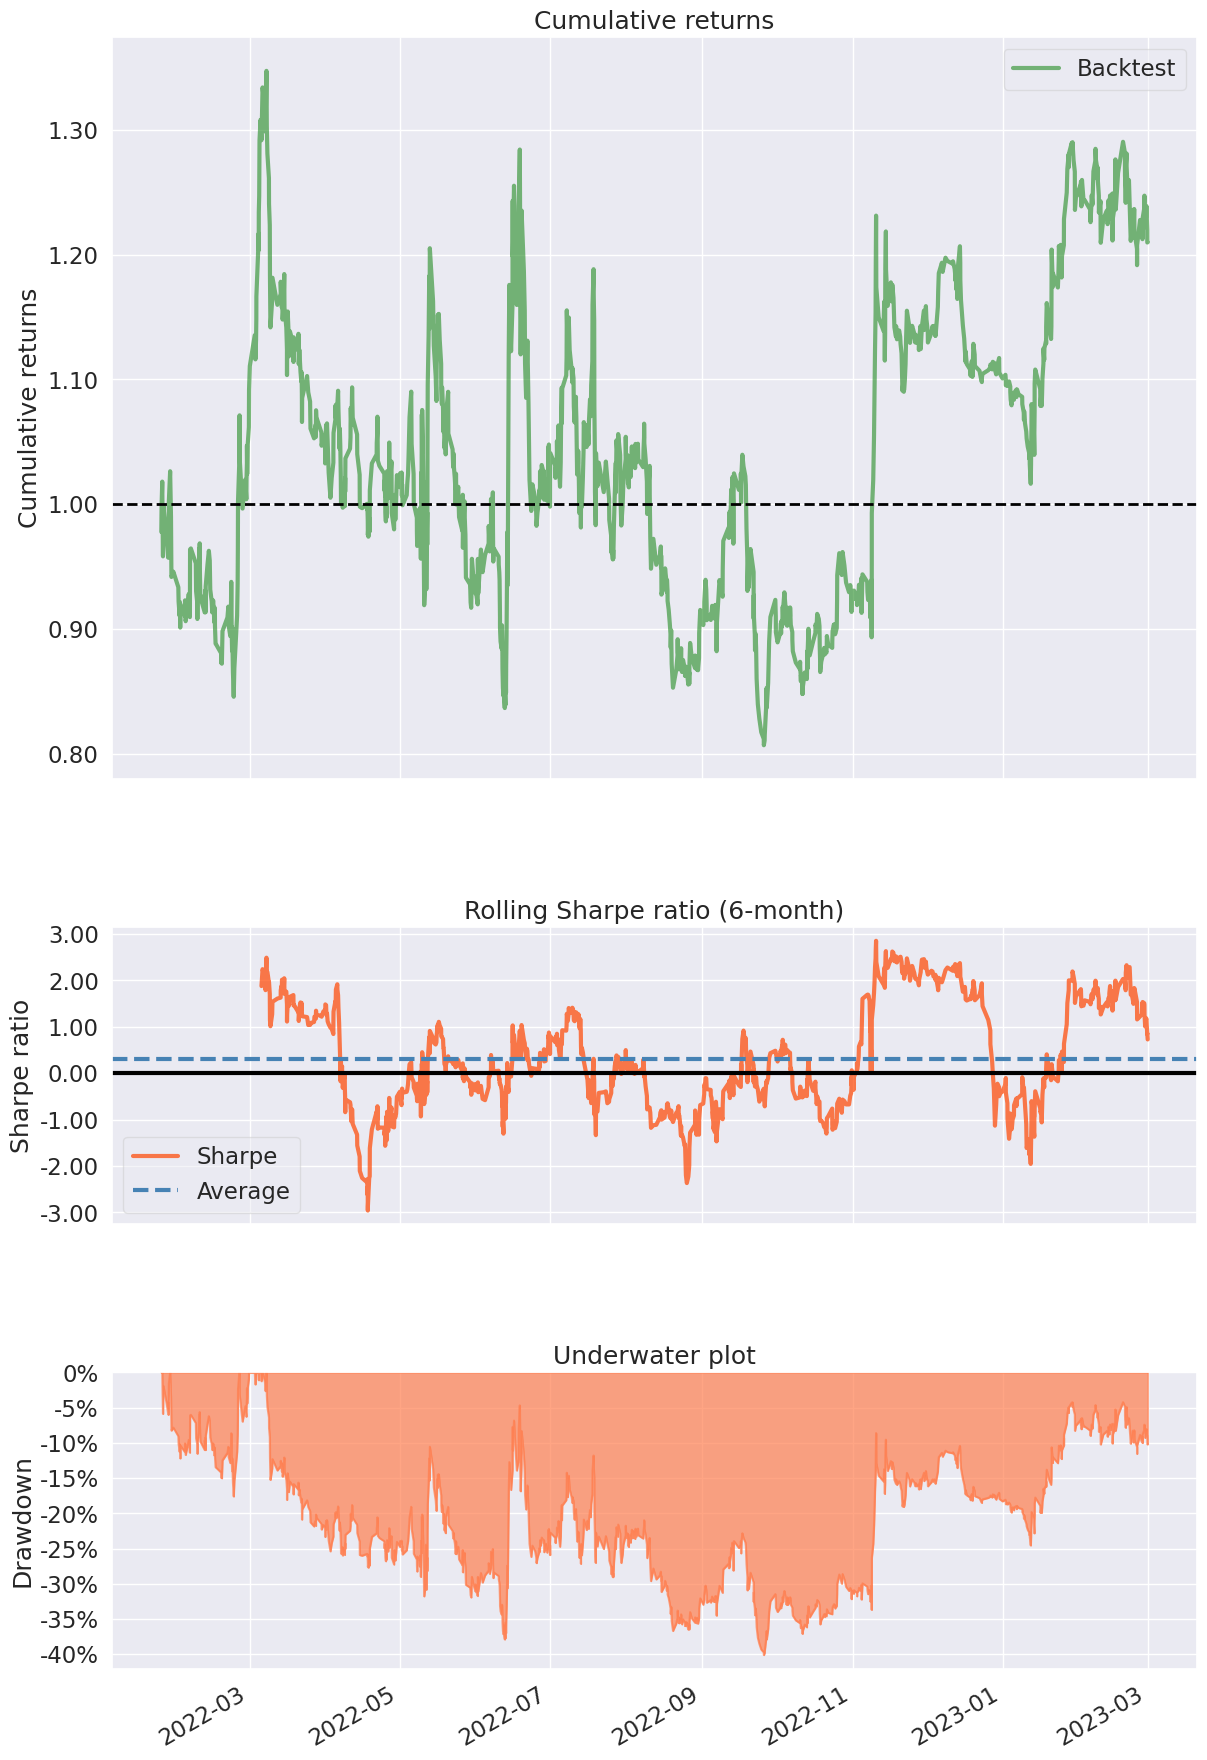

In [47]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [48]:
act_threshold = 0.7

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   84.254641
Equity Final [$]             103329379.605942
Equity Peak [$]              104304948.916799
Return [%]                            3.32938
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    3.284625
Volatility (Ann.) [%]                6.139057
Sharpe Ratio                         0.535037
Sortino Ratio                        0.892942
Calmar Ratio                          0.60616
Max. Drawdown [%]                   -5.418746
Avg. Drawdown [%]                   -0.116141
Max. Drawdown Duration      247 days 16:21:00
Avg. Drawdown Duration        2 days 03:54:00
# Trades                                 1222
Win Rate [%]                        47.545008
Best Trade [%]                       5.435855
Worst Trade [%]                     -6.364371
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,58
,Backtest
Annual return,3.8%
Cumulative returns,19.7%
Annual volatility,26.1%
Sharpe ratio,0.27
Calmar ratio,0.09
Stability,0.06
Max drawdown,-44.2%


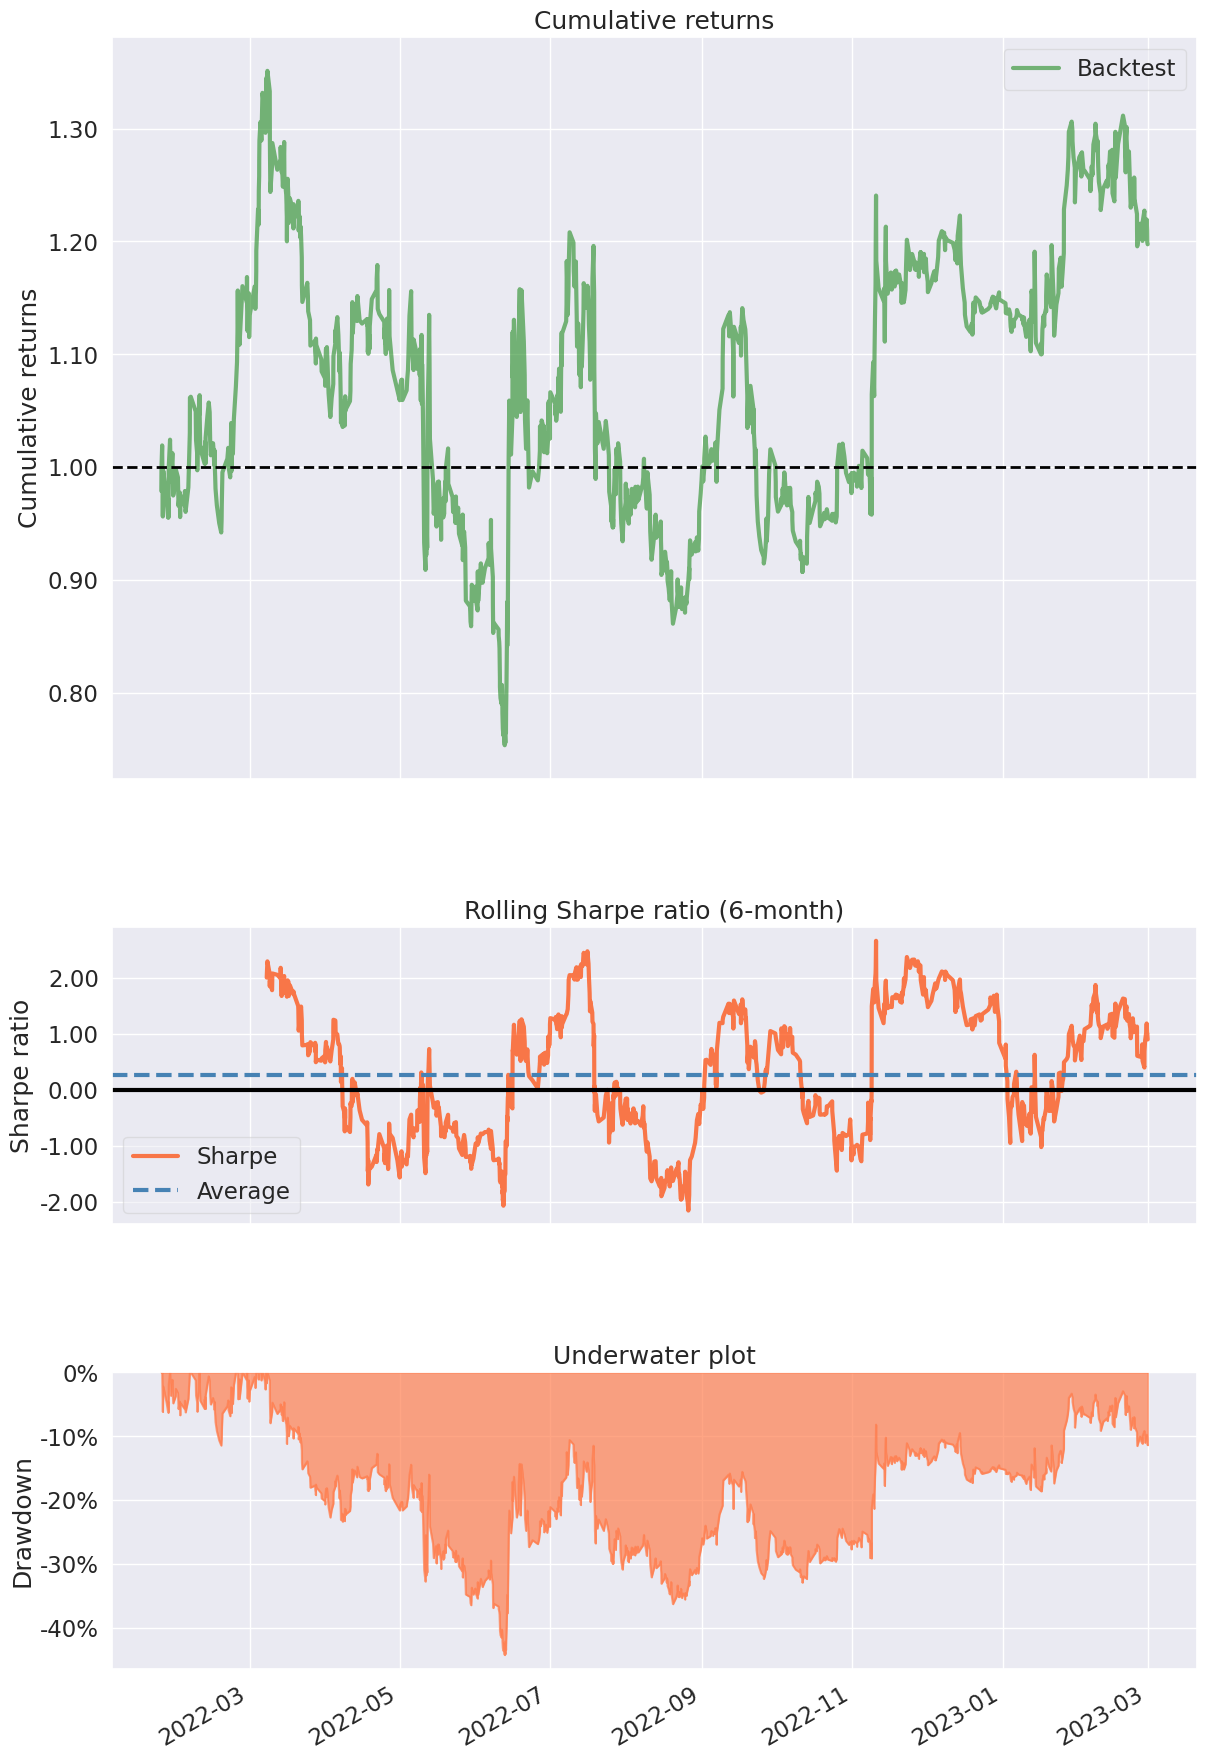

In [49]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [50]:
act_threshold = 0.71

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   80.566466
Equity Final [$]             104635124.335687
Equity Peak [$]              105605042.076006
Return [%]                           4.635124
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    4.658652
Volatility (Ann.) [%]                5.708622
Sharpe Ratio                         0.816073
Sortino Ratio                        1.392224
Calmar Ratio                         0.849948
Max. Drawdown [%]                   -5.481102
Avg. Drawdown [%]                   -0.108329
Max. Drawdown Duration      185 days 08:00:00
Avg. Drawdown Duration        1 days 19:24:00
# Trades                                 1130
Win Rate [%]                        47.964602
Best Trade [%]                       5.435855
Worst Trade [%]                     -4.666027
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,53
,Backtest
Annual return,7.3%
Cumulative returns,37.4%
Annual volatility,26.0%
Sharpe ratio,0.40
Calmar ratio,0.16
Stability,0.54
Max drawdown,-44.6%


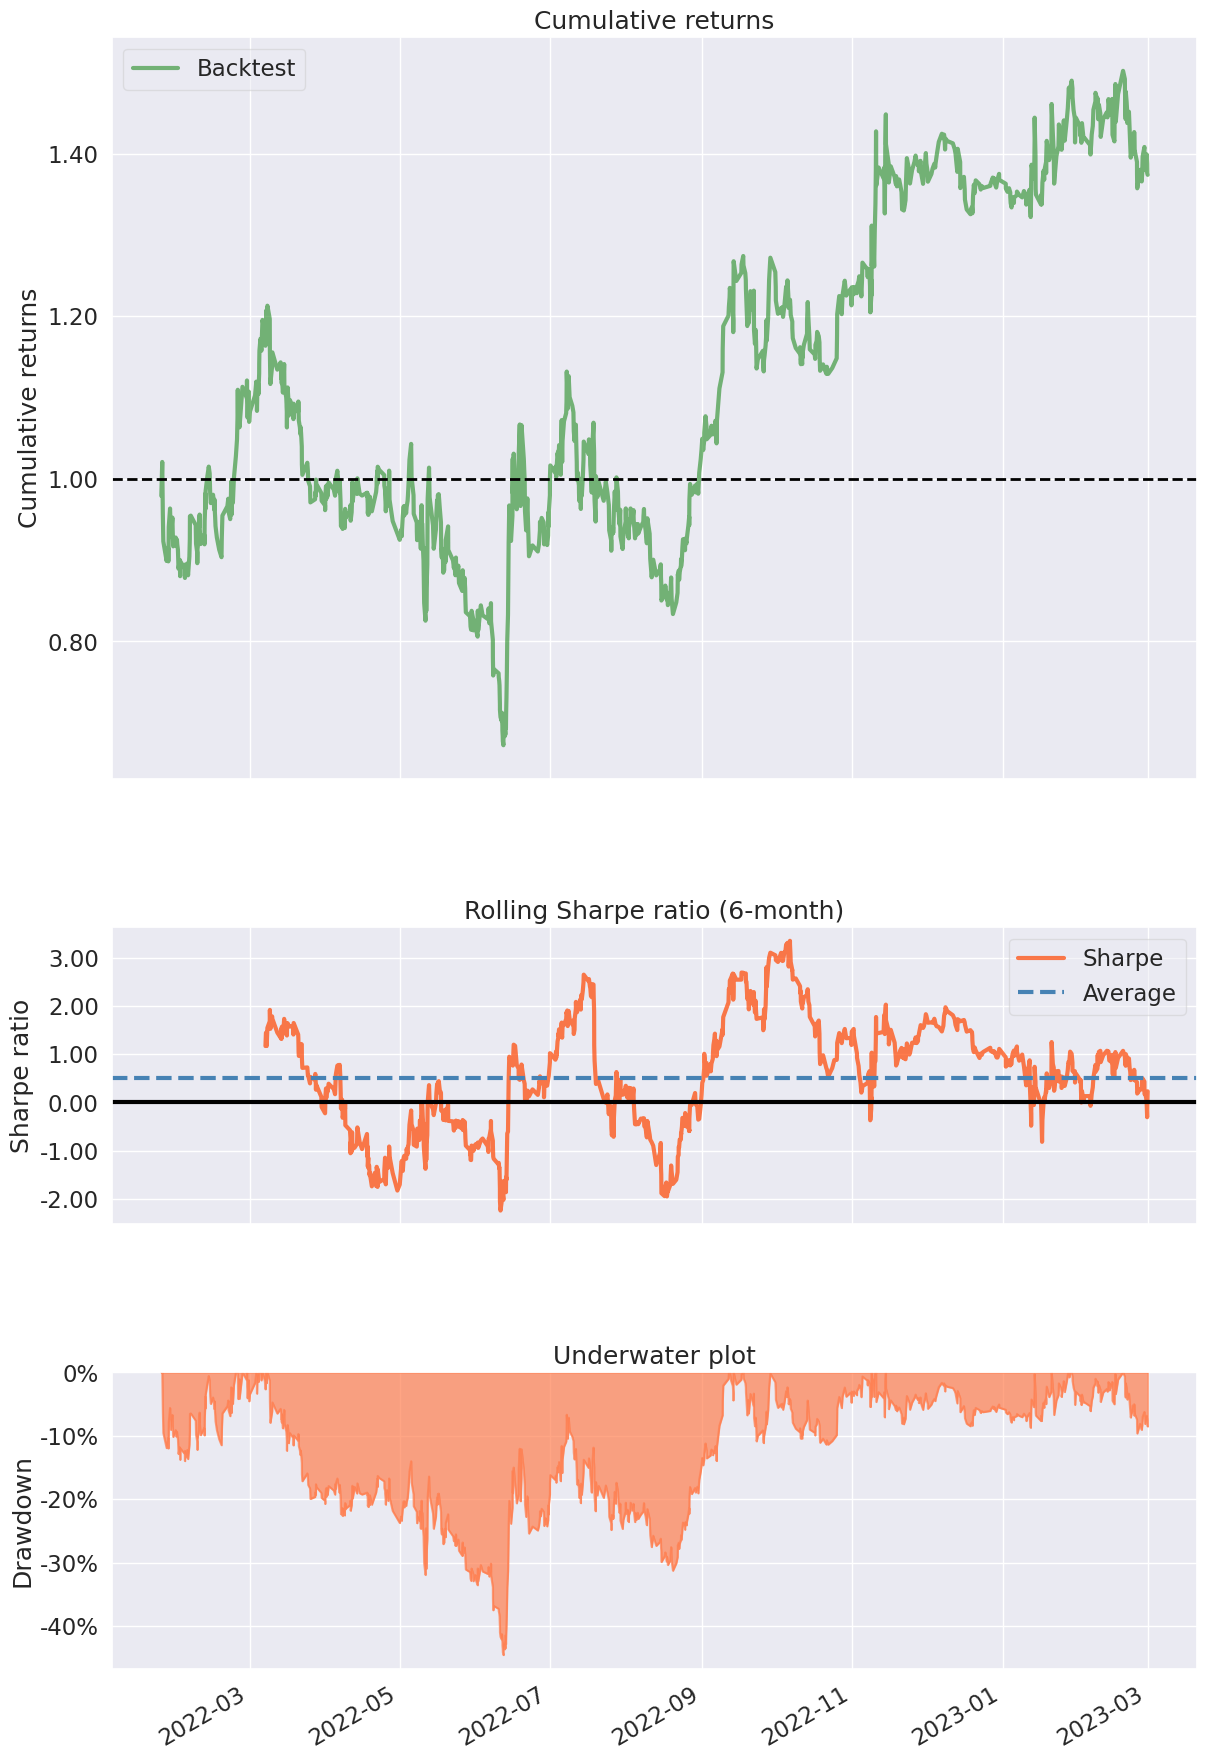

In [51]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [80]:
act_threshold = 0.75

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   62.579142
Equity Final [$]             103935268.717881
Equity Peak [$]              105574172.512443
Return [%]                           3.935269
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    4.095523
Volatility (Ann.) [%]                4.975312
Sharpe Ratio                         0.823169
Sortino Ratio                        1.399301
Calmar Ratio                         0.739818
Max. Drawdown [%]                   -5.535854
Avg. Drawdown [%]                   -0.090694
Max. Drawdown Duration      181 days 17:09:00
Avg. Drawdown Duration        1 days 13:07:00
# Trades                                  796
Win Rate [%]                        46.482412
Best Trade [%]                       6.019948
Worst Trade [%]                     -6.364371
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,37
,Backtest
Annual return,8.9%
Cumulative returns,31.1%
Annual volatility,28.6%
Sharpe ratio,0.44
Calmar ratio,0.20
Stability,0.44
Max drawdown,-44.2%


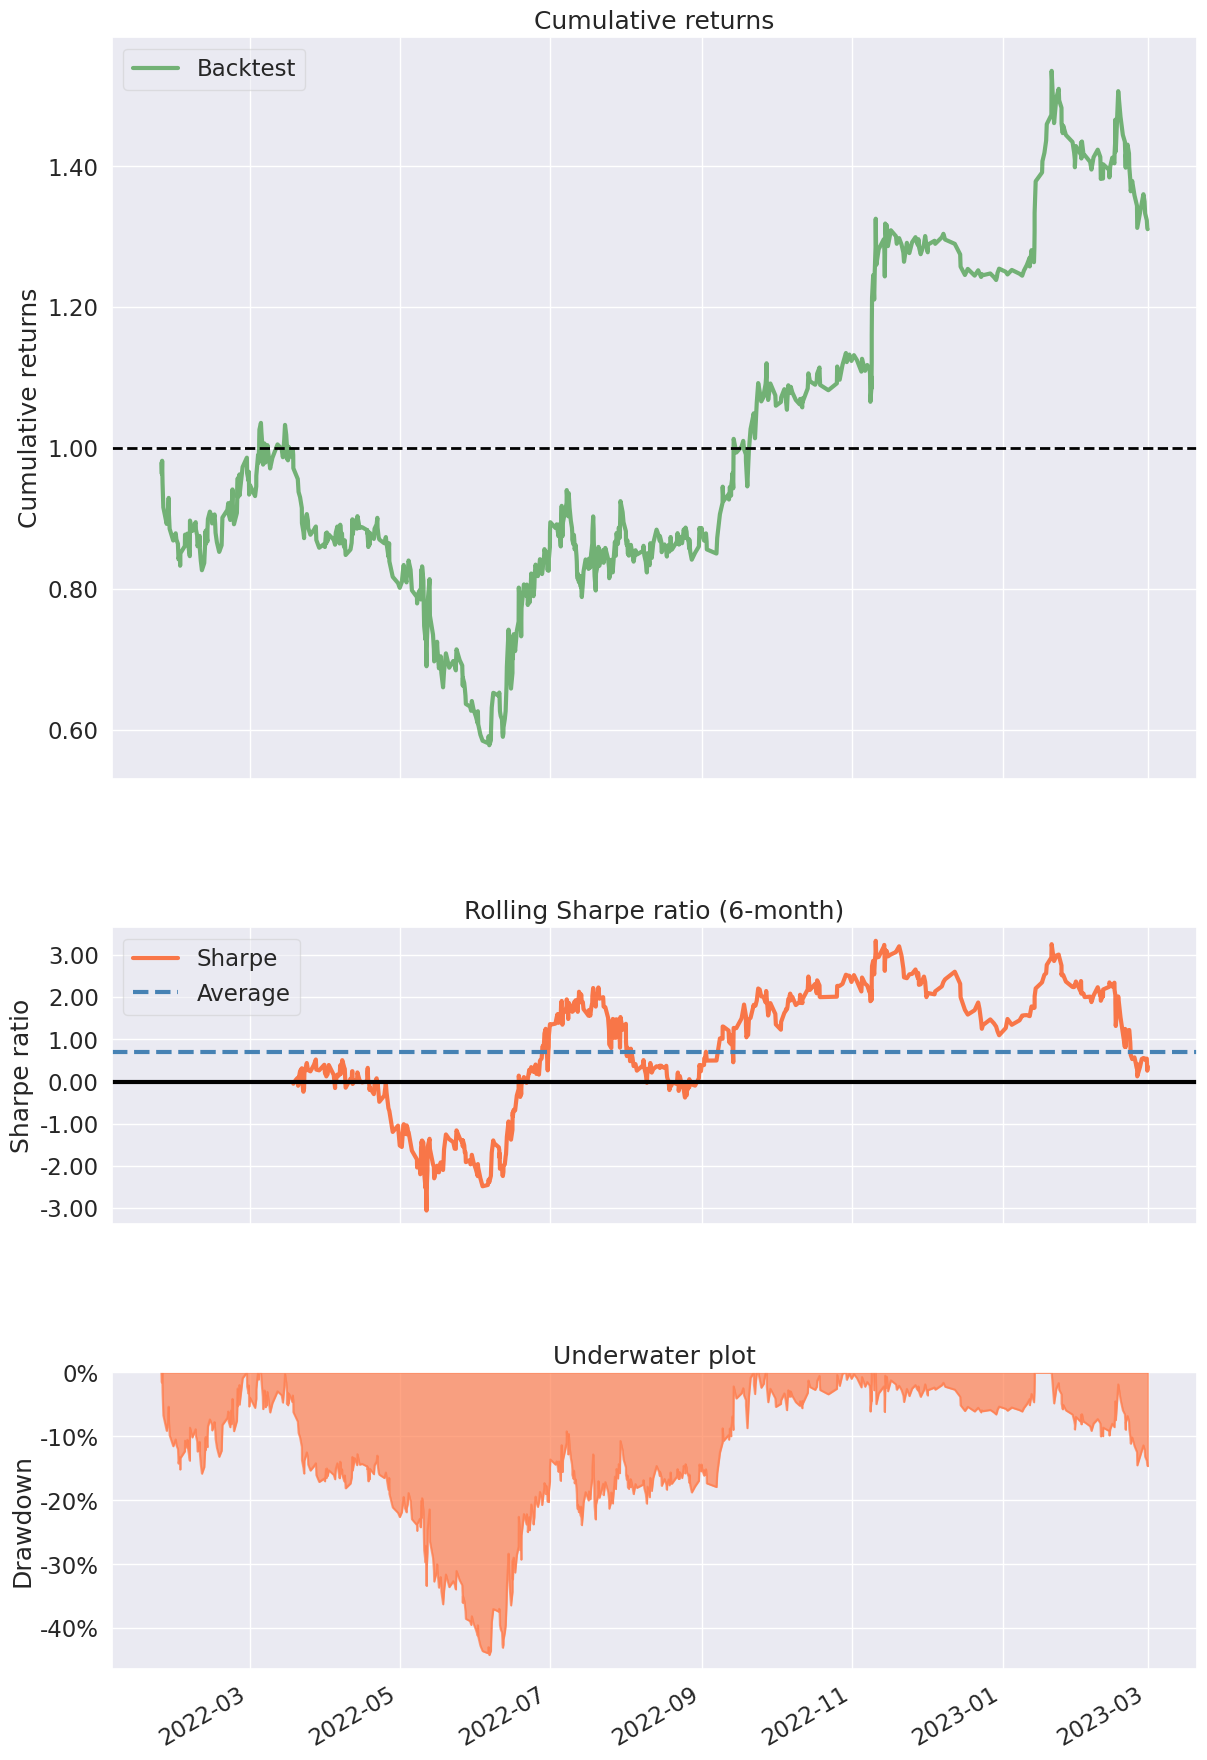

In [81]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [82]:
act_threshold = 0.75

class SideStrategy(Strategy):
    def init(self):
        super().init()
        self.last_position_dt = None

    def next(self):
        super().next()

        current_dt = self.data.index[-1]

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            if self.last_position_dt:
                delta_time = current_dt - self.last_position_dt
                if delta_time>datetime.timedelta(days=2):
                    self.position.close()
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        prob            = self.data.prob[-1]

        size=0.1

        if position==1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

        if position==-1 and prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)
            self.last_position_dt = current_dt

bt = Backtest(
    df["2022-01-24":], 
    SideStrategy, 
    cash             = 100000000, 
    #commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-24 00:00:00
End                       2023-02-28 23:59:00
Duration                    400 days 23:59:00
Exposure Time [%]                   62.579142
Equity Final [$]             107295351.563478
Equity Peak [$]              108699886.844042
Return [%]                           7.295352
Buy & Hold Return [%]              -36.060029
Return (Ann.) [%]                    7.133715
Volatility (Ann.) [%]                5.131018
Sharpe Ratio                         1.390312
Sortino Ratio                        2.525491
Calmar Ratio                         1.467124
Max. Drawdown [%]                   -4.862379
Avg. Drawdown [%]                   -0.085879
Max. Drawdown Duration      107 days 09:37:00
Avg. Drawdown Duration        0 days 23:34:00
# Trades                                  796
Win Rate [%]                         46.60804
Best Trade [%]                       6.062356
Worst Trade [%]                     -6.326917
Avg. Trade [%]                    

Start date,2022-01-24
End date,2023-02-28
Total months,37
,Backtest
Annual return,20.5%
Cumulative returns,80.2%
Annual volatility,28.6%
Sharpe ratio,0.79
Calmar ratio,0.51
Stability,0.68
Max drawdown,-39.9%


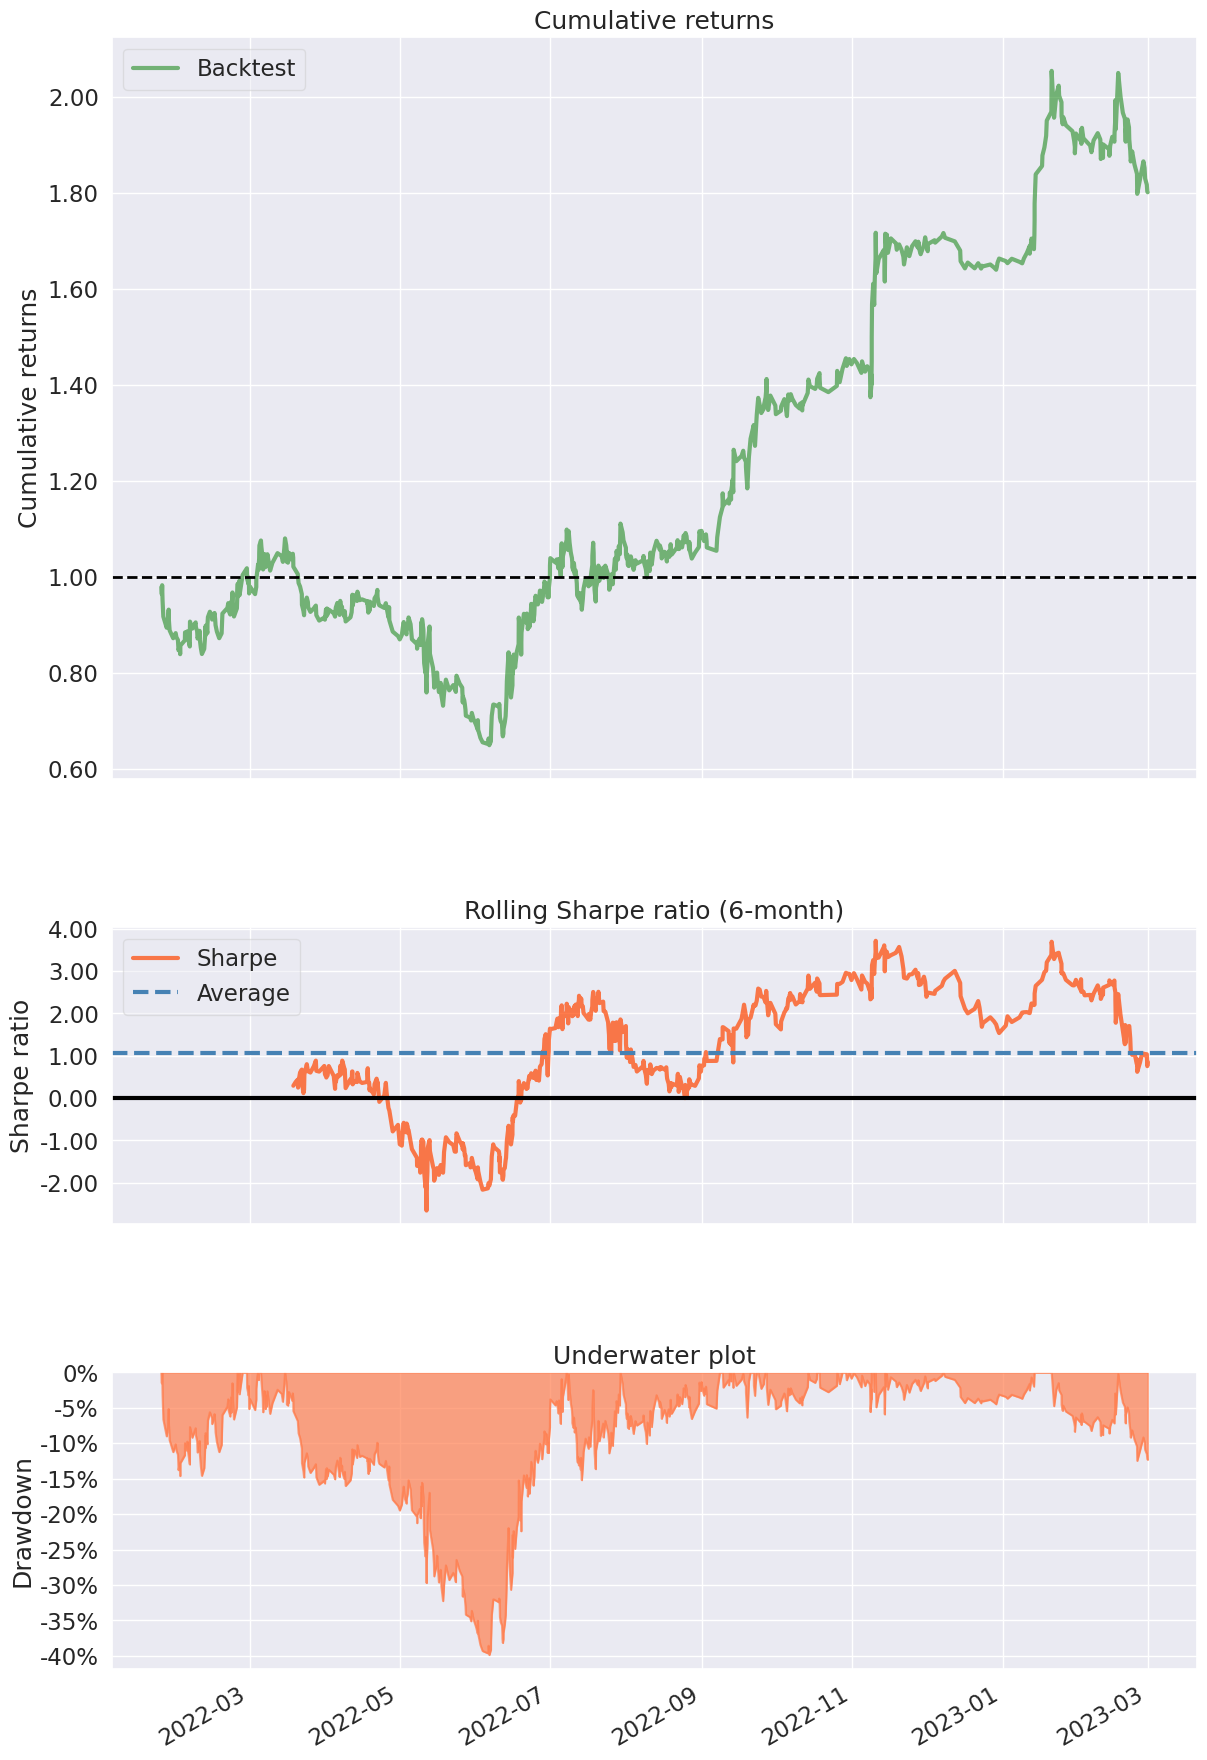

In [83]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])